In [5]:
base_dir = '/glade/work/kjmayer/research/catalyst/TransferLearning/runmean_analysis/artificial_bias/perfectmodel_TLtest/E3SM_analysis/'

import numpy as np
from scipy.ndimage import gaussian_filter
import xarray as xr
import os
import matplotlib.pyplot as plt
import matplotlib.colors as c
from cartopy import config
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker

plt.rc('text',usetex=True) 
plt.rc('xtick',color='dimgrey')
plt.rcParams['font.family']='sans-serif'
plt.rcParams['font.sans-serif']=['Verdana']
plt.rcParams.update({'font.size': 12})
def adjust_spines(ax, spines):
    for loc, spine in ax.spines.items():
        if loc in spines:
            spine.set_position(('outward', 5))
        else:
            spine.set_color('none')  
    if 'left' in spines:
        ax.yaxis.set_ticks_position('left')
    else:
        ax.yaxis.set_ticks([])
    if 'bottom' in spines:
        ax.xaxis.set_ticks_position('bottom')
        # ax.tick_params(colors='red', axis='x') 
    else:
        ax.xaxis.set_ticks([]) 

import sys
sys.path.append(base_dir+'functions/')
from exp_hp import get_hp
from utils import split_retrain

In [6]:
# loading for lat lon information for plotting
ppath = '/glade/derecho/scratch/kjmayer/DATA/E3SMv2/PRECT/'
pfiname = 'PRECT_mem0101_7daymean_1950-2014_20S-20N_regrid2.5x2.5_polydetrend_allmems.nc'
X = xr.open_dataarray(ppath+pfiname)

lat = X.lat
lon = X.lon

In [10]:
kk = 0
sign_str = 'pos'
EXP_NAME = 'exp2_kfold'
IG_dir = base_dir+'IG/data/kfold/'

In [11]:
entrycheck = 0
for SEED in range(10):
    ann1SD = np.load(IG_dir+'IG_ann1_60Eshift_'+EXP_NAME+'.'+str(kk)+'_'+sign_str+'conf_seed'+str(SEED)+'.npy',allow_pickle = True)
    if entrycheck == 0:
        IG_ann1SD = ann1SD
    else:
        IG_ann1SD = np.append(IG_ann1SD,ann1SD,axis = 0)
    entrycheck+=1

IG_ann1SD_mean = gaussian_filter(input=np.nanmean(IG_ann1SD,0), sigma = 0.75)

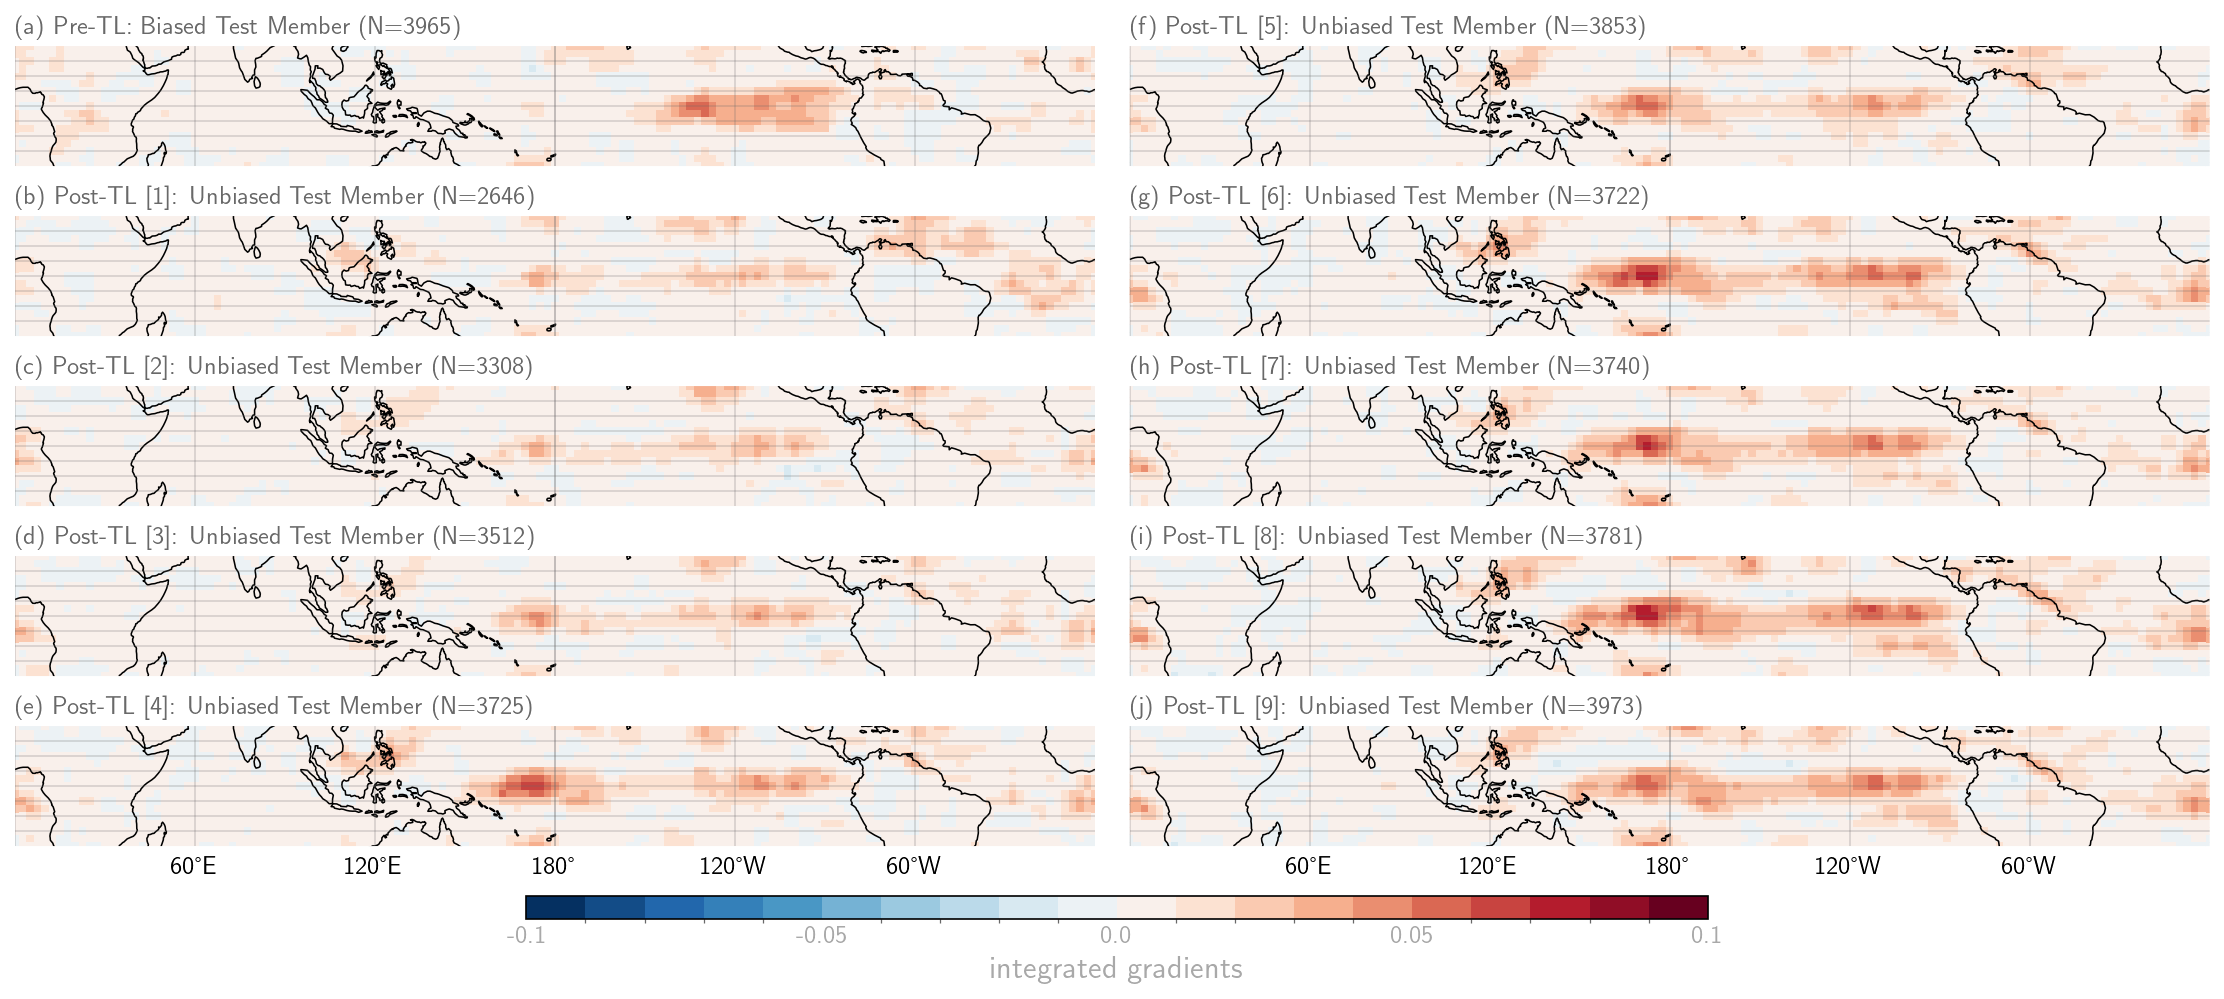

In [12]:
fig = plt.figure(figsize=(21,6))
ax = fig.subplot_mosaic('''
                        AF
                        BG
                        CH
                        DI
                        EJ
                        ''',subplot_kw={'projection':ccrs.PlateCarree(180)})
plt.tight_layout(pad=2)
for loc in ['A','B','C','D','E','F','G','H','I','J']:   
    adjust_spines(ax[loc], ['bottom'])
    ax[loc].coastlines(resolution='110m', color='k', linewidth=.75)
    ax[loc].set_ylim(-20,20)
    ax[loc].axis("off")
    gl = ax[loc].gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=.2, color='dimgrey')
    gl.top_labels = False
    gl.right_labels = False
    gl.left_labels = False
    if loc in ['E','J']:
        gl.bottom_labels = True
    else:
        gl.bottom_labels = False
     
cmap = 'RdBu_r'
csm=plt.get_cmap(cmap)
if sign_str == 'pos':
    norm = c.BoundaryNorm(np.arange(-0.1, 0.11, 0.01),csm.N)  
else:
    norm = c.BoundaryNorm(np.arange(-0.15, 0.16, 0.01),csm.N)
    
c1 = ax['A'].pcolormesh(lon, lat, IG_ann1SD_mean,cmap=csm,transform=ccrs.PlateCarree(),norm=norm)
ax['A'].set_title('(a) Pre-TL: Biased Test Member (N='+str(IG_ann1SD.shape[0])+')',
                  fontsize=12,color='dimgrey',loc='left')

EXP_NAME2 = 'exp2_retrain_increase_kfold'
IG_dir = base_dir+'IG/data/kfold/'

plot_loc = ['B','C','D','E','F','G','H','I','J']
plot_titlestr = ['(b)','(c)','(d)','(e)','(f)','(g)','(h)','(i)','(j)']
for i_trainmems in range(9):
    entrycheck = 0
    for SEED in range(10):
        if entrycheck == 0:
            IG_ann2noSD = np.load(IG_dir+'IG_ann2_60Eshift_'+EXP_NAME2+'.'+str(kk)+'.'+str(i_trainmems)+'_ann1-'+EXP_NAME+'_'+sign_str+'conf_seed'+str(SEED)+'.npy',allow_pickle = True)
        else:
            ann2noSD = np.load(IG_dir+'IG_ann2_60Eshift_'+EXP_NAME2+'.'+str(kk)+'.'+str(i_trainmems)+'_ann1-'+EXP_NAME+'_'+sign_str+'conf_seed'+str(SEED)+'.npy',allow_pickle = True)
            IG_ann2noSD = np.append(IG_ann2noSD,ann2noSD,axis = 0)
        entrycheck+=1

    IG_ann2noSD_mean = gaussian_filter(input=np.nanmean(IG_ann2noSD,0), sigma = 0.75)

    
    c1 = ax[plot_loc[i_trainmems]].pcolormesh(lon, lat, IG_ann2noSD_mean,cmap=csm,transform=ccrs.PlateCarree(),norm=norm)
    ax[plot_loc[i_trainmems]].set_title(plot_titlestr[i_trainmems]+' Post-TL ['+str(i_trainmems+1)+']: Unbiased Test Member (N='+str(IG_ann2noSD.shape[0])+')',
                      fontsize=12,color='dimgrey',loc='left')


cax2 = plt.axes([0.314,-0.025,0.375,0.025]) # left, vertical, width, height
if sign_str == 'pos':
    cbar2 = plt.colorbar(c1,cax=cax2,orientation = 'horizontal',fraction=0.04,
                         ticks=np.arange(-0.1, 0.105, 0.05))
    cbar2.ax.set_xticklabels(np.round(np.arange(-0.1, 0.105, 0.05),3),color='darkgrey')
else:
    cbar2 = plt.colorbar(c1,cax=cax2,orientation = 'horizontal',fraction=0.04,
                         ticks=np.arange(-0.15, 0.2, 0.05))
    cbar2.ax.set_xticklabels(np.round(np.arange(-0.15, 0.2, 0.05),3),color='darkgrey')
cbar2.ax.tick_params(size=0,labelsize=12)
cbar2.ax.set_xlabel('integrated gradients',fontsize=15,color='darkgrey')

# plt.show()
if sign_str == 'pos':
    plt.savefig('plots/FigureA7.png', dpi=300, transparent = True, bbox_inches = 'tight')
else:
    plt.savefig('plots/FigureA6.png', dpi=300, transparent = True, bbox_inches = 'tight')